In [1]:
import numpy as np
import pandas as pd
import torch
import warnings

from datetime import datetime
from matplotlib import pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

%matplotlib inline
warnings.filterwarnings(action='ignore', message='Setting attributes')

In [2]:
df = pd.read_excel("data/Train-m.xlsx", engine="openpyxl", index_col="date")
df.drop([x for x, y in zip((df < 0).any().index, (df < 0).any()) if y], axis=1, inplace=True)
df.index = pd.DatetimeIndex(df.index, freq="MS")

In [3]:
# df.plot(label="Цена EURO, руб", figsize=(16 * 3, 9 * 3))

In [4]:
dfs = [TimeSeries.from_times_and_values(df.index, df[cur_df_name].fillna(0) / max(df[cur_df_name].fillna(0))) for cur_df_name in df.columns]

In [5]:
model = NBEATSModel(
    input_chunk_length=18,
    output_chunk_length=12,
    num_blocks=2, num_layers=8,
    layer_widths=512, dropout=.15,
    n_epochs=15, random_state=23,
    pl_trainer_kwargs={"accelerator": "gpu", "devices": 1},
    optimizer_kwargs={"lr": 1e-5},
    save_checkpoints=True, model_name="Full-test",
    force_reset=True
)

In [6]:
model.fit(dfs, verbose=True)

2022-08-27 19:34:50 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-08-27 19:34:50 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-08-27 19:34:50 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-08-27 19:34:50 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-08-27 19:34:50 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-08-27 19:34:51 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 111 M 
---------------------------------------------------
111 M     Trainable params
2.7 K     Non-trainable params
111 M     Total params
889.

Training: 0it [00:00, ?it/s]

C:\Users\kozak\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:381: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)
2022-08-27 20:21:10 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=15` reached.


In [14]:
test_df = pd.read_excel("data/Test_example1.xlsx", engine="openpyxl", index_col="Unnamed: 0")
test_df.index = pd.DatetimeIndex(map(lambda x: datetime.strptime(f"20{int(x[0]) + 1}{x[1:]}", "%Ym%m"), test_df.index), freq="MS")

X_test = TimeSeries.from_series(test_df[test_df["Var4"] != "Forecast"]["Var4"].astype(np.float32) / max(test_df[test_df["Var4"] != "Forecast"]["Var4"].astype(np.float32)))
# y_test = TimeSeries.from_dataframe(test_df[test_df["Var4"] == "Forecast"])

2022-08-27 20:35:16 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 278it [00:00, ?it/s]

MAPE = 10.20%


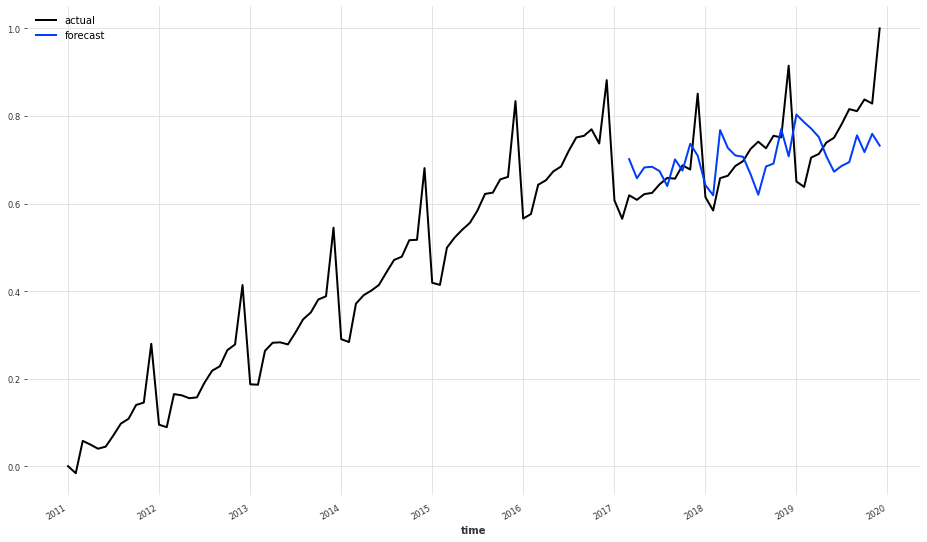

In [15]:
X_val, y_val = X_test.split_before(.7)

pred = model.predict(n=len(y_val), series=X_val)

plt.figure(figsize=(16, 9))
X_test.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(y_val, pred)))

In [9]:
# [idx for idx, x in enumerate(range(len(dfs))) if len(np.argwhere(np.isnan(dfs[x].all_values())))]